# LeNet

下面我们通过Sequential类来实现LeNet模型。

In [0]:
#导入所需的包和模块
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l
import torch as t
import torch.nn as nn
import torch.optim as opt
import time

In [0]:
#LeNet
class Flatten(nn.Module):#展平操作，为使卷积后的特征图输入全连接层分类器而施行的操作
    #不需要接受基类的一切，也没有需要添加的子类数据成员，仅重构forward操作即可，__init__、super可不必
    def forward(self,x):
        return x.view(x.shape[0],-1)#(batch_size,C*H*W)
    
class Reshape(nn.Module):#将图像大小重定型为（batch_szie,C,H,W），与Flatten()相反操作
    def forward(self,x):
        return x.view(-1,1,28,28)#(b,C,H,W)
    
net=nn.Sequential(
    Reshape(),
    #卷积层块
    nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,padding=2),#b*1*28*28->b*6*28*28，形状不变，通道数增加
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),#b*6*28*28->b*6*14*14
    nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),#无填充，形状缩小，增加更多的通道以获取更多的特征，b*6*14*14->b*16*10*10
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),#b*16*10*10->b*16*5*5
    Flatten(),#b*16*5*5->b*400
    #全连接层块
    nn.Linear(in_features=400,out_features=120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)
print(net)

Sequential(
  (0): Reshape()
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Sigmoid()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Flatten()
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


接下来我们构造一个高和宽均为28的单通道数据样本，并逐层进行前向计算来查看每个层的输出形状。

In [0]:
X=t.randn((1,1,28,28),dtype=t.float)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Reshape output shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


## 获取数据和训练模型

下面我们来实现LeNet模型。我们仍然使用Fashion-MNIST作为训练数据集。

In [0]:
#数据
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)
print(len(train_iter))

235


为了使读者更加形象的看到数据，添加额外的部分来展示数据的图像

torch.Size([256, 1, 28, 28])
torch.Size([1, 28, 28]) 9
torch.Size([1, 28, 28]) 3
torch.Size([1, 28, 28]) 0
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 4
torch.Size([1, 28, 28]) 9
torch.Size([1, 28, 28]) 2
torch.Size([1, 28, 28]) 0
torch.Size([1, 28, 28]) 3
torch.Size([1, 28, 28]) 1


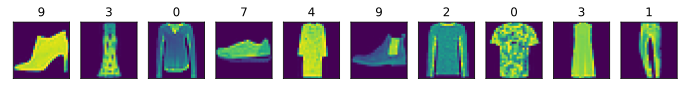

In [0]:
#数据展示
%matplotlib inline
import matplotlib.pyplot as plt
def show_fashion_mnist(images,labels):
    d2l.use_svg_display()
    _,figs=plt.subplots(1,len(images),figsize=(12,12))
    for f,img,lbl in zip(figs,images,labels):
        f.imshow(img.view((28,28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)#隐去坐标轴
        f.axes.get_yaxis().set_visible(False)
    plt.show()
    
for Xdata,ylabel in train_iter:
    break
    
X,y=[],[]
print(Xdata.shape)
for i in range(10):
    print(Xdata[i].shape,ylabel[i].numpy())
    X.append(Xdata[i]) # 将第i个feature加到X中
    y.append(ylabel[i].numpy()) # 将第i个label加到y中
show_fashion_mnist(X, y)
#show_fashion_mnist(Xdata[:10],ylabel[:10].numpy())#直接这样更快

因为卷积神经网络计算比多层感知机要复杂，建议使用GPU来加速计算。我们查看看是否可以用GPU，如果成功则使用`cuda:0`，否则仍然使用`cpu`。

In [0]:
#这个函数将被放在d2lzh_pytorch中
#使用GPU
def try_gpu():
    """如果 GPU 可以使用，返回 torch.device('cuda:0')；否则返回 torch.device('cpu')."""
    if t.cuda.is_available():
        device = t.device('cuda:0')
    else:
        device = t.device('cpu')
    return device

device = try_gpu()
device

device(type='cpu')

我们实现`evaluate_accuracy`函数，该函数用于计算模型`net`在数据集`data_iter`上的准确率。

In [0]:
#计算准确率
'''
(1). net.train()
  启用 BatchNormalization 和 Dropout，将BatchNormalization和Dropout置为True
(2). net.eval()
不启用 BatchNormalization 和 Dropout，将BatchNormalization和Dropout置为False
'''

def evaluate_accuracy(data_iter,net,device=try_gpu()):
    "在给定数据集上评估模型"
    acc_sum,n=t.tensor([0],dtype=t.float32,device=device),0
    for X,y in data_iter:
        #如果device是GPU，复制数据到GPU上
        X,y=X.to(device),y.to(device)
        net.eval()#启动评估模式
        with t.no_grad():#没必要，就是计入计算图也不影响
            y=y.long()
            acc_sum += t.sum((t.argmax(net(X), dim=1) == y))  #[[0.2 ,0.4 ,0.5 ,0.6 ,0.8] ,[ 0.1,0.2 ,0.4 ,0.3 ,0.1]] => [ 4 , 2 ]
            n += y.shape[0]
    return acc_sum.item()/n#整个给定数据集上平均准确率

我们定义函数`train_ch5`，用于训练模型。

In [0]:
#训练函数
def train_ch5(net, train_iter, test_iter,criterion, num_epochs, batch_size, device,lr=None):
    """在 CPU 或者 GPU 上训练、评估模型."""
    print('training on', device)
    net.to(device)
    optimizer = opt.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        train_l_sum = t.tensor([0.0],dtype=t.float32,device=device)
        train_acc_sum = t.tensor([0.0],dtype=t.float32,device=device)
        n, start = 0, time.time()
        for X, y in train_iter:
            net.train()#启动训练模式
            
            optimizer.zero_grad()#梯度清零
            X,y = X.to(device),y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            
            with t.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (t.sum((t.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net,device)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc,
                 time.time() - start))

我们重新将模型参数初始化到对应的设备`device`(`cpu` or `cuda:0`)之上，并使用Xavier随机初始化。损失函数和训练算法则依然使用交叉熵损失函数和小批量随机梯度下降。

In [0]:
# 训练
lr, num_epochs = 0.9, 10

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        t.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
net = net.to(device)

criterion = nn.CrossEntropyLoss()   #交叉熵描述了两个概率分布之间的距离，交叉熵越小说明两者之间越接近
train_ch5(net, train_iter, test_iter, criterion,num_epochs, batch_size,device, lr)

training on cpu
epoch 1, loss 0.0091, train acc 0.100, test acc 0.100, time 277.7 sec
epoch 2, loss 0.0085, train acc 0.167, test acc 0.432, time 294.3 sec
epoch 3, loss 0.0040, train acc 0.589, test acc 0.674, time 224.9 sec
epoch 4, loss 0.0030, train acc 0.696, test acc 0.735, time 252.9 sec
epoch 5, loss 0.0026, train acc 0.736, test acc 0.739, time 235.4 sec
epoch 6, loss 0.0024, train acc 0.764, test acc 0.732, time 253.6 sec
epoch 7, loss 0.0022, train acc 0.783, test acc 0.771, time 268.2 sec
epoch 8, loss 0.0021, train acc 0.796, test acc 0.799, time 277.1 sec
epoch 9, loss 0.0020, train acc 0.811, test acc 0.820, time 269.2 sec
epoch 10, loss 0.0019, train acc 0.822, test acc 0.805, time 272.5 sec


In [0]:
# test
for testdata,testlable in test_iter:
    testdata,testlable = testdata.to(device),testlable.to(device)
    break
print(testdata.shape,testlable.shape)
net.eval()
y_pre = net(testdata)
print(t.argmax(y_pre,dim=1)[:10])
print(testlable[:10])

torch.Size([256, 1, 28, 28]) torch.Size([256])
tensor([9, 0, 3, 0, 0, 2, 7, 2, 5, 5])
tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


## 总结：

卷积神经网络就是含卷积层的网络。
LeNet交替使用卷积层和平均池化层后接全连接层来进行图像分类。